# 2. Estimating Underperformance

### Data
Use the returns on the S&P 500 ($r^m$) and 1-month T-bills, ($r^f$) provided in `barnstable_analysis_data.xlsx`.

- Data goes through `END_YR=2024`.

Barnstable’s estimates of mean and volatility are based on the subsample of 1965 to 1999.

- We consider this subsample, as well as 2000-{END_YR}, as well as the full sample of 1926-{END_YR}.

### Notation
- $r$ = level return rates

- $R$ = cumulative return factor

- $\text{r}$ = log return rates

$$
R = 1 + r
$$

$$
\text{r} = \ln(1 + r) = \ln(R)
$$

In [2]:
import sys
sys.path.append('..')

import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils import *
from scipy.stats import norm

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

In [17]:
data = pd.read_excel("../data/barnstable_analysis_data.xlsx", sheet_name = "data").set_index("date")
data = data.dropna()
data.head()

,SPX,TB1M
date,,
1926-01-30,-0.001783,0.003061
1926-02-27,-0.033297,0.002612
1926-03-31,-0.057708,0.002601
1926-04-30,0.038522,0.002270
1926-05-28,0.013623,0.002691


In [18]:
sample_1965_1999 = data[(data.index.year >= 1965) & (data.index.year <= 1999)]
sample_2000_2024 = data[(data.index.year >= 2000) & (data.index.year <= 2024)]
sample_1926_2024 = data[(data.index.year >= 1926) & (data.index.year <= 2024)]

## 1. Summary Statistics

Report the following (annualized) statistics.

In [ ]:
# def CalcLevelReturnsSTD(returns: pd.Series):
#     levelReturns = (1 + returns).prod()
#     numYear = len(returns) / 12
#     mean = levelReturns ** (1 / numYear) - 1
#     std = returns.std() * np.sqrt(12)
#     return (mean, std)

def CalcLevelReturnsSTD(returns: pd.Series):
    return (returns.mean() * 12, returns.std() * np.sqrt(12))

def LevelandLogReturns(data: pd.DataFrame):
    data = data.dropna()
    market, rf = data["SPX"], data["TB1M"]
    excessReturn = market - rf
    
    # Level Returns
    ## SPX
    marketLevelMean, marketLevelSTD = CalcLevelReturnsSTD(market)
    ## Risk Free
    rfLevelMean, rfLevelSTD = CalcLevelReturnsSTD(rf)
    ## Excess Returns
    excessLevelMean, excessLevelSTD = CalcLevelReturnsSTD(excessReturn)
    
    # Log Returns
    marketLogReturns = np.log1p(market)
    rfLogReturns = np.log1p(rf)
    
    ## SPX
    marketLogMean = marketLogReturns.mean() * 12
    marketLogSTD = marketLogReturns.std() * np.sqrt(12)
    
    ## Risk Free
    rfLogMean = rfLogReturns.mean() * 12
    rfLogSTD = rfLogReturns.std() * np.sqrt(12)

    ## Excess Return = np.log1p(SPX) - np.log1p(Risk Free)
    excessLogReturns = marketLogReturns - rfLogReturns
    excessLogMean = excessLogReturns.mean() * 12
    excessLogSTD = excessLogReturns.std() * np.sqrt(12)
    
    return (marketLevelMean, marketLevelSTD, rfLevelMean, rfLevelSTD, excessLevelMean, excessLevelSTD, marketLogMean, marketLogSTD, rfLogMean, rfLogSTD, excessLogMean, excessLogSTD)

In [20]:
def CreateSummarStats(data: pd.DataFrame):
    marketLevelMean, marketLevelSTD, rfLevelMean, rfLevelSTD, excessLevelMean, excessLevelSTD, marketLogMean, marketLogSTD, rfLogMean, rfLogSTD, excessLogMean, excessLogSTD = LevelandLogReturns(data)
    result = pd.DataFrame({
        "Mean": [marketLevelMean, excessLevelMean, rfLevelMean, marketLogMean, excessLogMean, rfLogMean],
        "Vol": [marketLevelSTD, excessLevelSTD, rfLevelSTD, marketLogSTD, excessLogSTD, rfLogSTD]
    })
    result.index = pd.MultiIndex.from_tuples([
            ('levels', 'r^m'), ('levels', 'r̃^m'), ('levels', 'r^f'),
            ('logs', 'r^m'), ('logs', 'r̃^m'), ('logs', 'r_f')
    ])
    return result

In [21]:
result_1965_1999 = CreateSummarStats(sample_1965_1999)
result_2000_2024 = CreateSummarStats(sample_2000_2024)
result_1926_2024 = CreateSummarStats(sample_1926_2024)
result2_1 = pd.DataFrame({
    ('1965-1999', 'mean'): result_1965_1999['Mean'],
    ('1965-1999', 'vol'): result_1965_1999['Vol'],
    ('2000-2024', 'mean'): result_2000_2024['Mean'],
    ('2000-2024', 'vol'): result_2000_2024['Vol'],
    ('1926-2024', 'mean'): result_1926_2024['Mean'],
    ('1926-2024', 'vol'): result_1926_2024['Vol']
}).round(4)

result2_1

1965-1999         2000-2024         1926-2024        
                 mean     vol      mean     vol      mean     vol
levels r^m     0.1302  0.1495    0.0875  0.1528    0.1152  0.1870
       r̃^m    0.0687  0.1502    0.0701  0.1531    0.0833  0.1873
       r^f     0.0615  0.0072    0.0175  0.0056    0.0319  0.0085
logs   r^m     0.1184  0.1497    0.0756  0.1538    0.0975  0.1863
       r̃^m    0.0571  0.1504    0.0581  0.1540    0.0656  0.1866
       r_f     0.0613  0.0071    0.0174  0.0055    0.0318  0.0085

- Return: `1965-1999` > `1926-2024` > `2000-2024`
- Volatility: `1926-2024` > `2000-2024` > `1965-1999`

- Because of the volatility drag of financial data, **geometric mean** (log return) is always less than the **arithmetic mean** (level return)

---

## 2. Probability of Underperformance

Recall the following:

- If $x \sim N(\mu_x, \sigma^2_x)$, then
$$
\mathbb{P}[x < \ell] = \Phi_N(L)
$$
where $\mathbb{L} = \frac{l-\mu_x}{\sigma_x}$ and $\Phi_N$ denotes the standard normal cdf

- Remember that cumulative log returns are simply the sum of the single-period log returns:

$$
\mathbf{r}^{m}_{t,t+h} \equiv \sum_{i=1}^{h} \mathbf{r}^{m}_{t+i}
$$

- It will be convenient to use and denote sample averages. We use the following notation for an $h$-period average ending at time $t+h$:

$$
\mathbf{\bar{r}}^{m}_{t,t+h} = \frac{1}{h} \sum_{i=1}^{h} \mathbf{r}^{m}_{t+i}
$$

Calculate the probability that the cumulative market return will fall short of the cumulative risk-free return:

$$
\mathbb{P}[R^m_{t, t+h} < R^f_{t, t+h}]
$$

To analyze this analytically, convert the probability statement above to a probability statement about mean log returns.

### 2.1

Calculate the probability using the subsample 1965-1999.

In [ ]:
def Underperformance(returns: pd.DataFrame, horizon: int):
    spxLogReturn = np.log1p(returns["SPX"])
    tbillLogReturn = np.log1p(returns["TB1M"])
    excessReturn = spxLogReturn - tbillLogReturn

    excessReturnMean = excessReturn.mean()
    excessReturnSTD = excessReturn.std()
    
    month = horizon * 12
    mean = excessReturnMean * month
    std = excessReturnSTD * np.sqrt(month)
    
    l = (0 - mean) / std
    prob = norm.cdf(l)
    
    return round(float(prob), 4)

: 

: 

: 

: 

In [ ]:
Underperformance(sample_1965_1999, 35)

0.0124

: 

: 

: 

: 

### 2.2
Report the precise probability for $h=15$ and $h=30$ years.

In [ ]:
prob15 = Underperformance(sample_1965_1999, 15)
prob30 = Underperformance(sample_1965_1999, 30)

print(f"Probability of Underperformance for 15 yr horizon: {prob15}")
print(f"Probability of Underperformance for 30 yr horizon: {prob30}")

Probability of Underperformance for 15 yr horizon: 0.0708
Probability of Underperformance for 30 yr horizon: 0.0188


: 

: 

: 

: 

### 2.3
Plot the probability as a function of the investment horizon, $h$, for $0 < h \leq 30$  years.

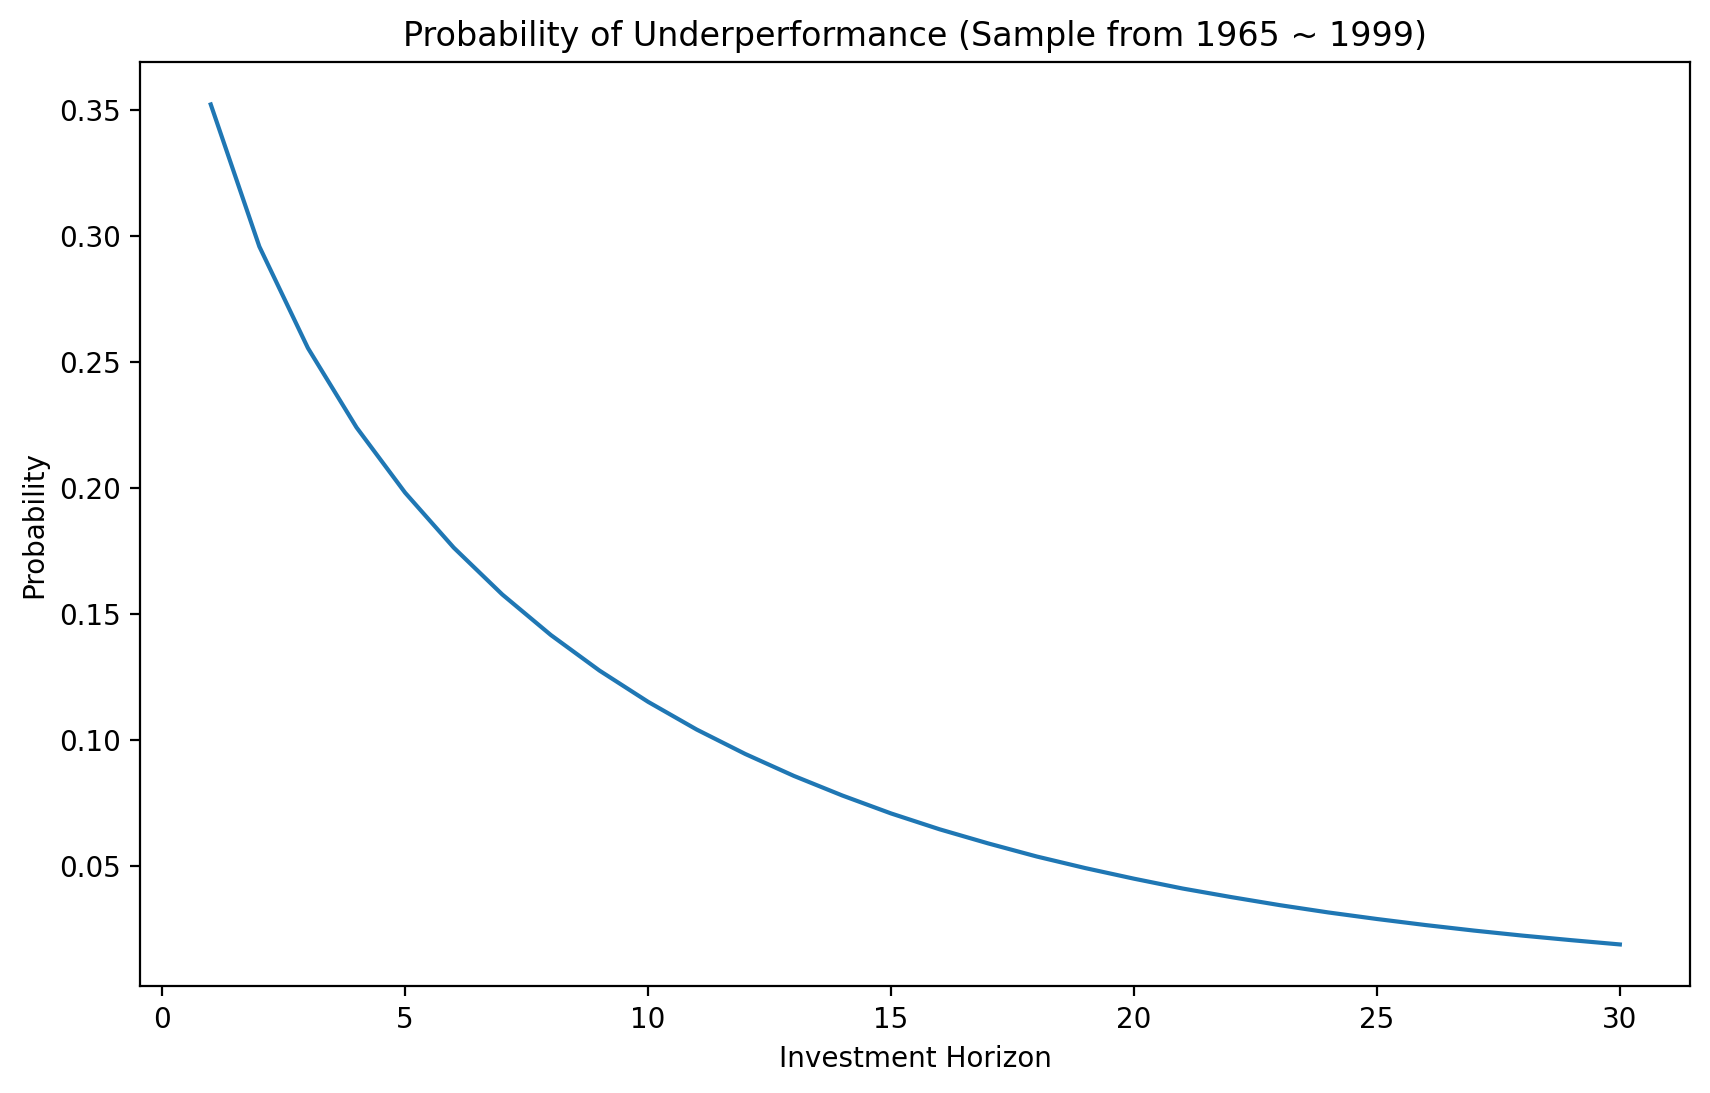

: 

: 

: 

: 

In [ ]:
prob = list()

for i in range(31):
    prob.append(Underperformance(sample_1965_1999, i))

plt.figure(figsize = (10, 6))
plt.plot(prob)
plt.title("Probability of Underperformance (Sample from 1965 ~ 1999)")
plt.xlabel("Investment Horizon")
plt.ylabel("Probability")
plt.show()

The longer you stay invested in the market, the lower your chance of underperforming the risk-free rate

Hint: The probability can be expressed as:

$$
p(h) = \Phi_N(-\sqrt(h)SR)
$$

where $SR$ denotes the sample Sharpe ratio of log market returns.

$$
l = \frac{0 - (h*\mu_{excess\ log\ return})}{\sqrt(h) * \sigma_{excess\ log\ return}} = -\sqrt(h)\frac{\mu_{excess\ log\ return}}{\sigma_{excess\ log\ return}} = -\sqrt(h) * SR
$$

---

## 3. Full Sample Analysis

Use the sample 1965-{END_YR} to reconsider the 30-year probability. As of the end of {END_YR}, calculate the probability of the stock return underperforming the risk-free rate over the next 30 years. That is, $R^m_{t,t+h}$ underperforming $R^f_{t,t+h}$ for $0 < h \leq 30$

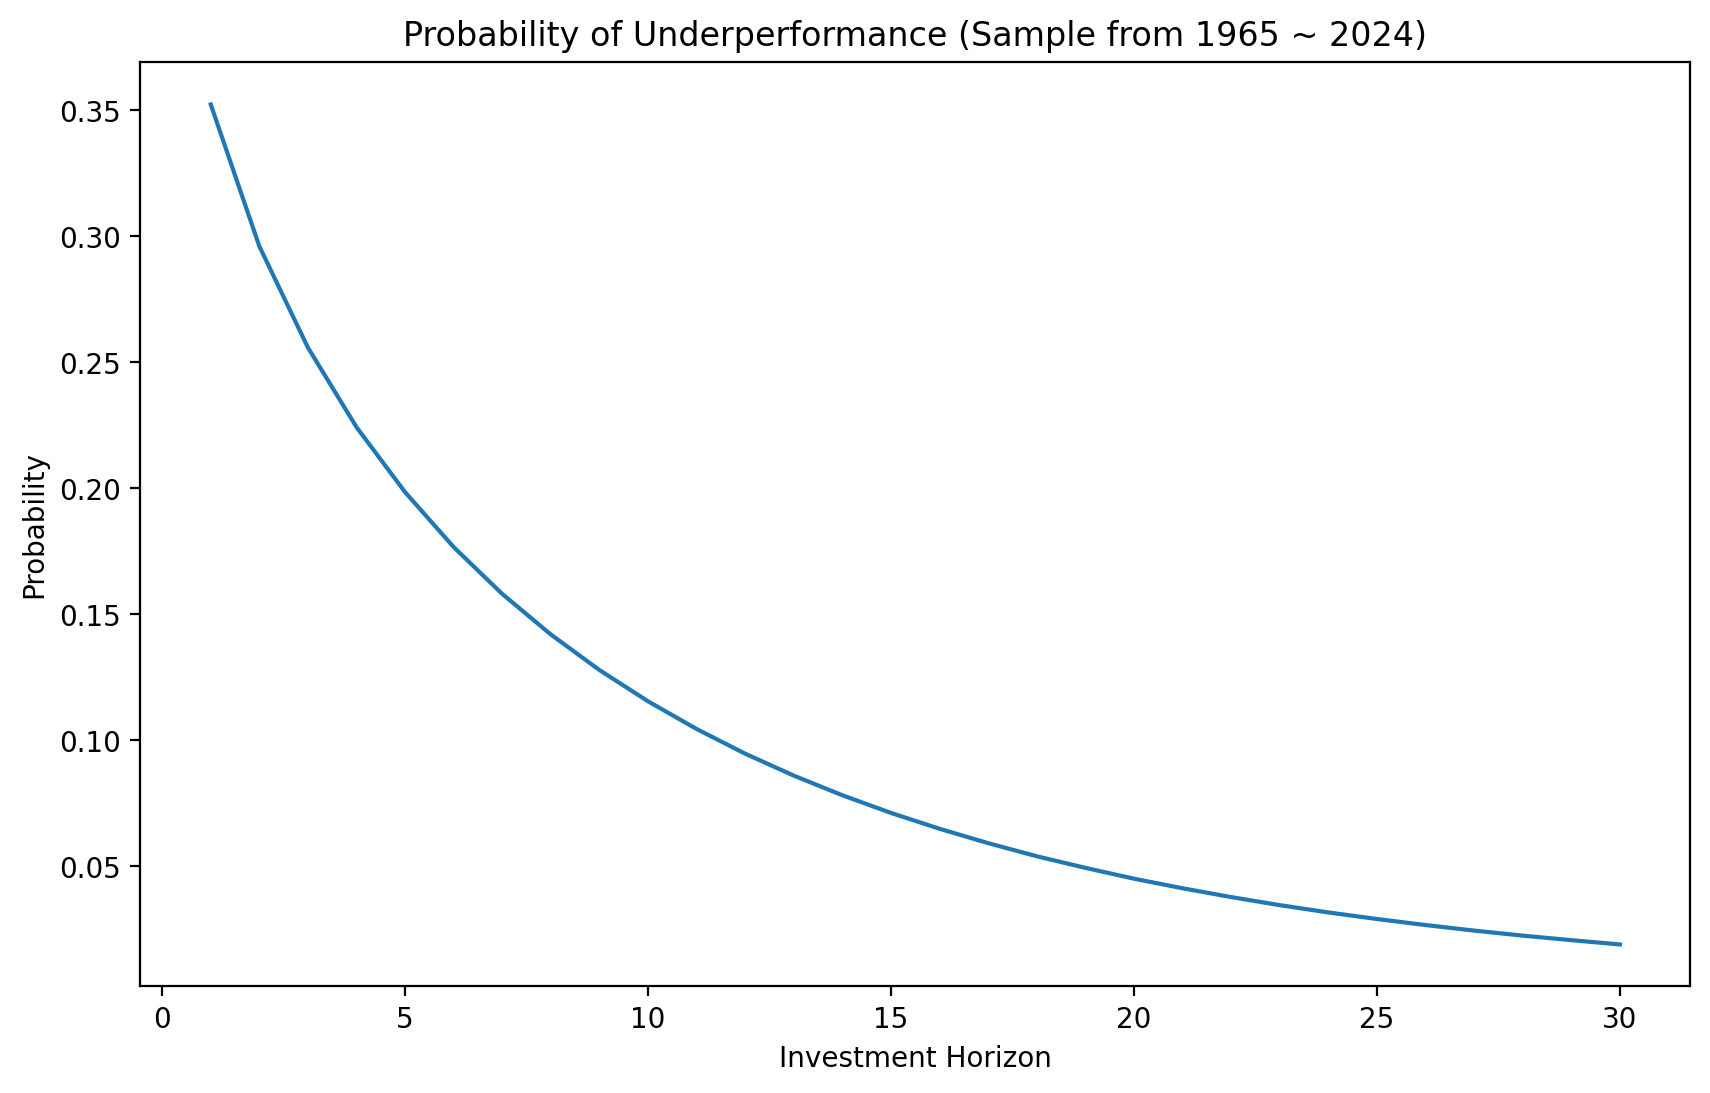

: 

: 

: 

: 

In [ ]:
sample_1965_2024 = data[(data.index.year >= 1965) & (data.index.year <= 2024)]
prob = list()

for i in range(31):
    prob.append(Underperformance(sample_1965_2024, i))

plt.figure(figsize = (10, 6))
plt.plot(prob)
plt.title("Probability of Underperformance (Sample from 1965 ~ 2024)")
plt.xlabel("Investment Horizon")
plt.ylabel("Probability")
plt.show()

---

## 4. In-Sample Estimate of Out-of-Sample Likelihood

Let’s consider how things turned out relative to Barnstable’s 1999 expectations.

What was the probability (based on the 1999 estimate of $\mu$) that the `h`-year market return, $R^m_{t,t+h}$, would be smaller than that realized in `2000-{END_YR}`?

Hint: You can calculate this as:

$$
p = \Phi_N \left( \sqrt{h} \frac{\bar{\mathbf{r}}_{\text{out-of-sample}} - \bar{\mathbf{r}}_{\text{in-sample}}}{\sigma_{\text{in-sample}}} \right)
$$

where “in-sample” denotes 1965-1999 and “out-of-sample” denotes 2000-{END_YR}.

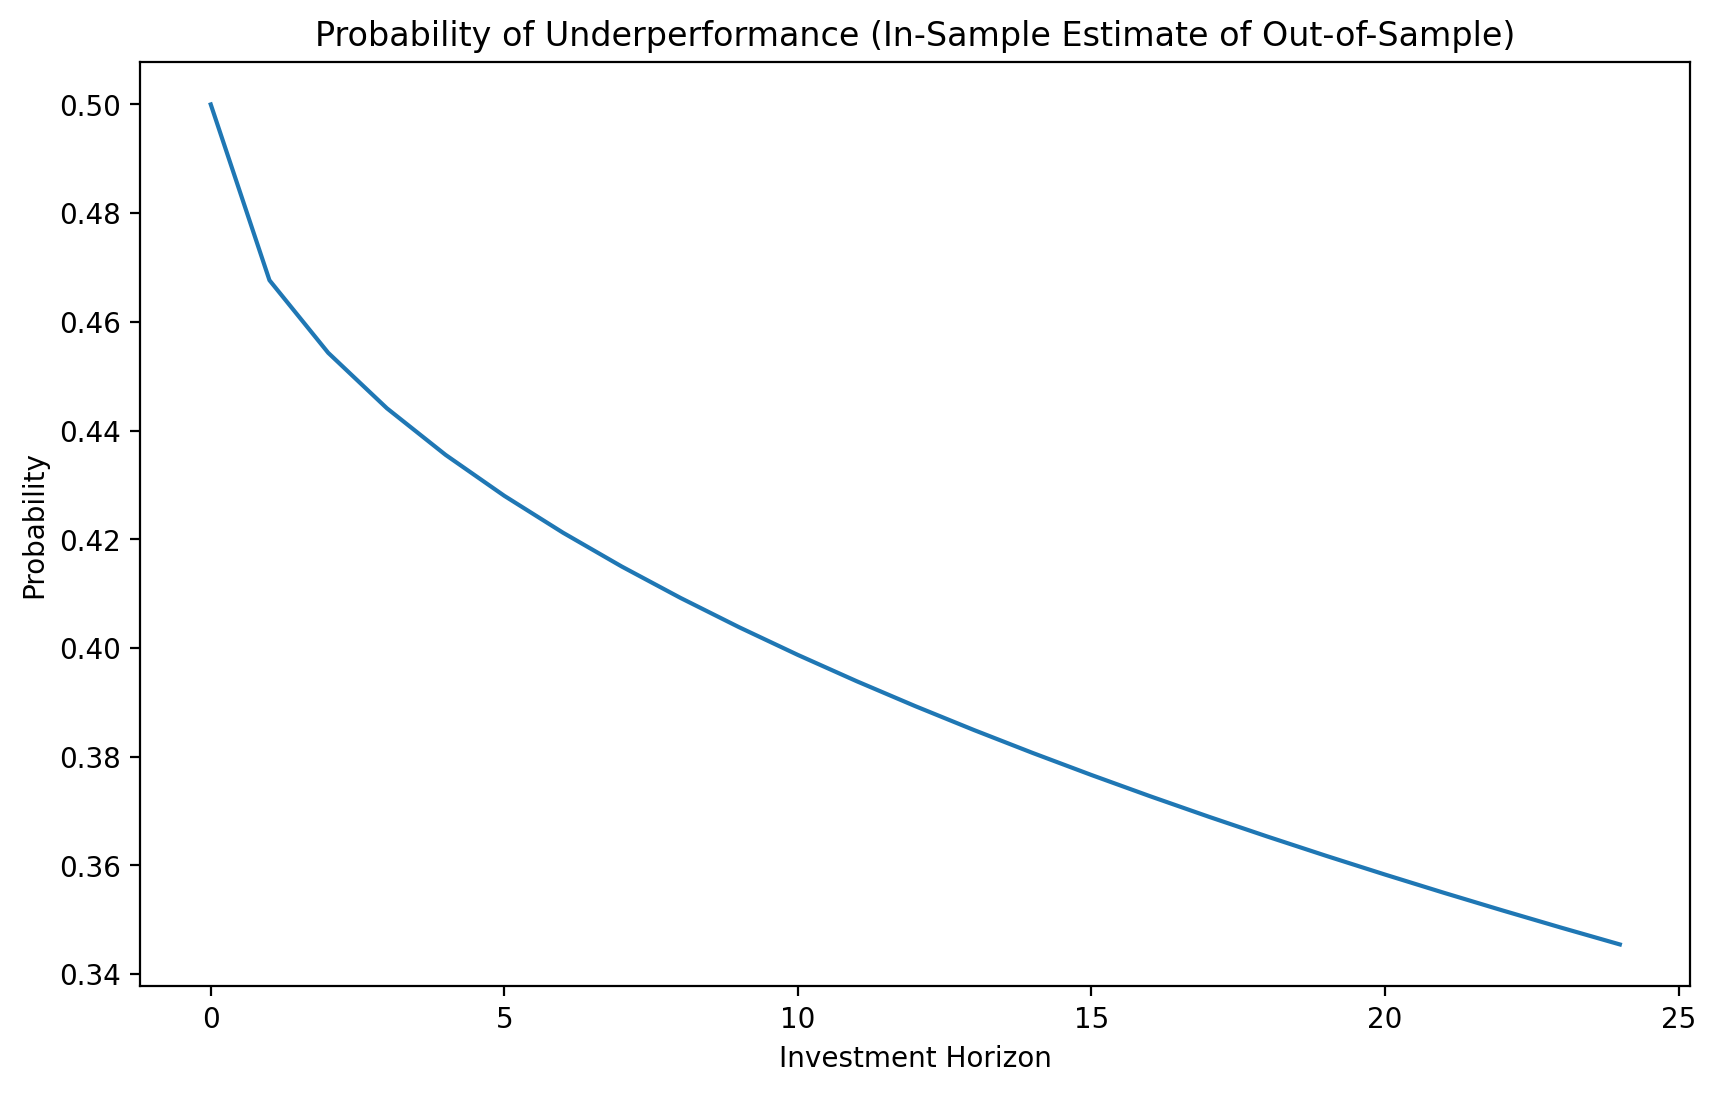

: 

: 

: 

: 

In [ ]:
InSample = np.log1p(sample_1965_1999["SPX"])
meanInSample = InSample.mean()
stdInSample = InSample.std()
meanOOS = np.log1p(sample_2000_2024["SPX"]).mean()

prob = list()

for i in range(25):
    prob.append(norm.cdf(np.sqrt(i) * (meanOOS - meanInSample) / stdInSample))
    
plt.figure(figsize = (10, 6))
plt.plot(prob)
plt.title("Probability of Underperformance (In-Sample Estimate of Out-of-Sample)")
plt.xlabel("Investment Horizon")
plt.ylabel("Probability")
plt.show()

---

# Exercise - VaR

### Data
This problem uses weekly return data from `data/spx_returns_weekly.xlsx`.

Choose any 4 stocks to evaluate below.

For example,

- AAPL

- META

- NVDA

- TSLA

## 1. Diversification

In [ ]:
data = pd.read_excel("../data/spx_returns_weekly.xlsx", sheet_name = "s&p500 rets").set_index("date")
tickers = ["AAPL", "META", "NVDA", "TSLA"]
data = data[tickers]
data.head()

,AAPL,META,NVDA,TSLA
date,,,,
2015-01-09,0.024514,-0.009055,-0.009315,-0.057685
2015-01-16,-0.053745,-0.032931,0.000836,-0.065760
2015-01-23,0.065950,0.035255,0.037578,0.042575
2015-01-30,0.036997,-0.024669,-0.072636,0.011476
2015-02-06,0.019114,-0.018967,0.062269,0.067589


: 

: 

: 

: 

### 1.1

Using the full sample, calculate for each series the (unconditional)

- volatility

- empirical VaR (.05)

- empirical CVaR (.05)

Recall that by **empirical** we refer to the direct quantile estimation. (For example, using `.quantile()` in pandas.)

In [ ]:
vol, var, cvar = list(), list(), list()
for ticker in tickers:
    priceData = data[ticker]
    vol.append(priceData.std() * np.sqrt(52)) # weekly data
    var.append(CalcVar(priceData))
    cvar.append(CalcCVar(priceData))
    
result1 = pd.DataFrame({
    "Volatility": vol,
    "VaR": var,
    "CVaR": cvar
}, index = tickers)
result1

,Volatility,VaR,CVaR
AAPL,0.276629,-0.056366,-0.083125
META,0.351336,-0.070012,-0.103196
NVDA,0.463283,-0.086853,-0.116455
TSLA,0.586431,-0.117397,-0.147814


: 

: 

: 

: 

### 1.2

Form an equally-weighted portfolio of the investments.

Calculate the statistics of `1.1` for this portfolio, and compare the results to the individual return statistics. What do you find? What is driving this result?

In [ ]:
weights = np.array([1/len(tickers) for _ in tickers])
portfolio = data @ weights
portVol = portfolio.std() * np.sqrt(52)
portVar = CalcVar(portfolio)
portCVar = CalcCVar(portfolio)

vol.append(portVol)
var.append(portVar)
cvar.append(portCVar)

print(f"Portfolio Volatility: {portVol:.4f}")
print(f"Portfolio VaR: {portVar:.4f}")
print(f"Portfolio CVaR: {portCVar:.4f}")

Portfolio Volatility: 0.3155
Portfolio VaR: -0.0619
Portfolio CVaR: -0.0850


: 

: 

: 

: 

In [ ]:
result1 = pd.DataFrame({
    "Volatility": vol,
    "VaR": var,
    "CVaR": cvar
}, index = tickers + ["Portfolio"])

: 

: 

: 

: 

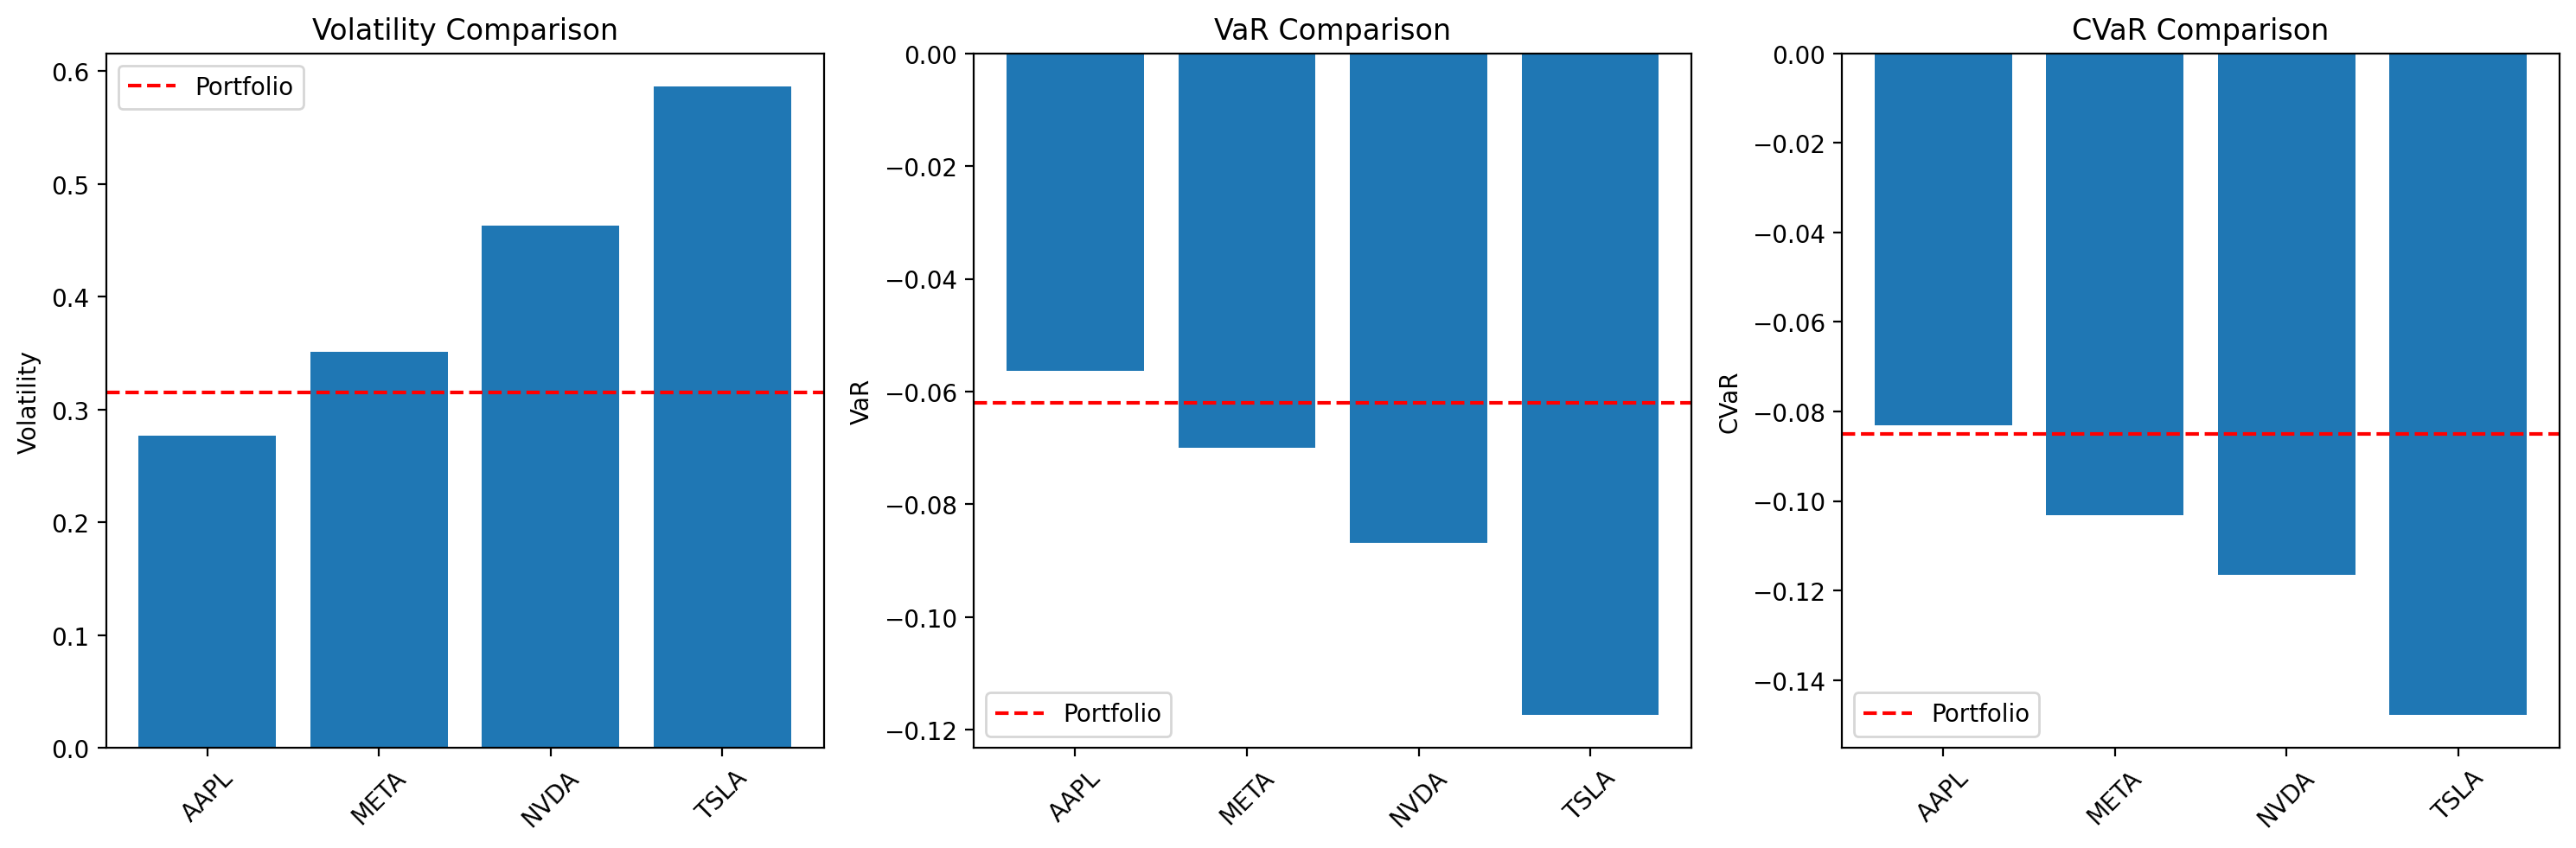

: 

: 

: 

: 

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
for idx, col in enumerate(["Volatility", "VaR", "CVaR"]):
    axes[idx].bar(result1.index[:-1], result1[col].iloc[:-1])
    axes[idx].set_title(f"{col} Comparison")
    axes[idx].set_ylabel(col)
    axes[idx].tick_params(axis = "x", rotation = 45)
    axes[idx].axhline(y = result1[col]["Portfolio"], color="r", 
                      linestyle = "--", label = "Portfolio")
    axes[idx].legend()

plt.tight_layout()
plt.show()

### 1.3

Re-calculate `1.2`, but this time drop your most volatile asset, and replace the portion it was getting with 0. (You could imagine we’re replacing the most volatile asset with a negligibly small risk-free rate.)

In comparing the answer here to `1.2`, how much risk is your most volatile asset adding to the portfolio? Is this in line with the amount of risk we measured in the stand-alone risk-assessment of `1.1`?

In [ ]:
dataRmVolatile = data.copy()
mostVolatile = result1["Volatility"].idxmax()
dataRmVolatile[mostVolatile] = 0
portRmVolatile = dataRmVolatile @ weights

port2Vol = portRmVolatile.std() * np.sqrt(52)
port2Var = CalcVar(portRmVolatile)
port2CVar = CalcCVar(portRmVolatile)

result3 = pd.DataFrame({
    "Volatility": [portVol, port2Vol],
    "VaR": [portVar, port2Var],
    "CVar": [portCVar, port2CVar]
}, index = [f"With {mostVolatile}", f"WithOut {mostVolatile}"])
result3

,Volatility,VaR,CVar
With TSLA,0.315543,-0.061950,-0.084992
WithOut TSLA,0.218365,-0.042463,-0.060531


: 

: 

: 

: 

## 2. Dynamic Measures

### 2.1
Let’s measure the **conditional** statistics of the equally-weighted portfolio of `1.2`, as of the end of the sample.

#### Volatility
For each security, calculate the **rolling** volatility series, $\sigma_t$, with a window of $m=26$.

The value at $\sigma_t$ in the notes denotes the estimate using data through time $t-1$, and thus (potentially) predicting the volatility at $\sigma_t$.

#### Mean
Suppose we can approximate that the daily mean return is zero.

#### VaR
Calculate the **normal VaR** and **normal CVaR** for $q=0.05$ and $\tau=1$ as of the end of the sample. Use the approximation, $z_{.05} = -1.65$.

$$
VaR_q = \mu + z_q \times \sigma_t
$$

#### CVaR

$$
CVaR_q = E[R|R<VaR_q] = E[\mu + \sigma Z | Z < z_q]
$$

$$
CVaR_q = E[\mu] + \sigma E[Z | Z < z_q]
$$

Integral Definition

$$
E[Z \mid Z < z_q] = \frac{\int_{-\infty}^{z_q} z \cdot \phi(z) \, dz}{\int_{-\infty}^{z_q} \phi(z) \, dz}
$$

Simplifying the Denominator

$$
\int_{-\infty}^{z_q} \phi(z) \, dz = \Phi_N(z_q) = q
$$

Solve $\int_{-\infty}^{z_q} z \cdot \phi(z) \, dz$

$$
\phi(z) = \frac{1}{\sqrt{2 \pi}} \, \exp^{-\frac{z^2}{2}} dz
$$

Simplifying the Integral

$$
\int_{-\infty}^{z_q} z \cdot \phi(z) \, dz = \left[-\phi(z)\right]_{-\infty}^{z_q} = -\phi(z_q) - (-\phi(-\infty)) 
$$

Putting It All Together

$$
E[Z|Z<z_q] = \frac{\phi(z_q)}{q}
$$

$$
CVaR_q = \mu - \sigma\,\frac{\phi(z_q)}{q}
$$

#### Notation Note
In this setup, we are using a forecasted volatility, $\sigma_t$ to estimate the VaR return we would have estimated at the end of $t-1$ in prediction of time $t$.

#### Conclude and Compare
Report

- volatility (annualized).

- normal VaR (.05)

- normal CVaR (.05)

How do these compare to the answers in `1.2`?

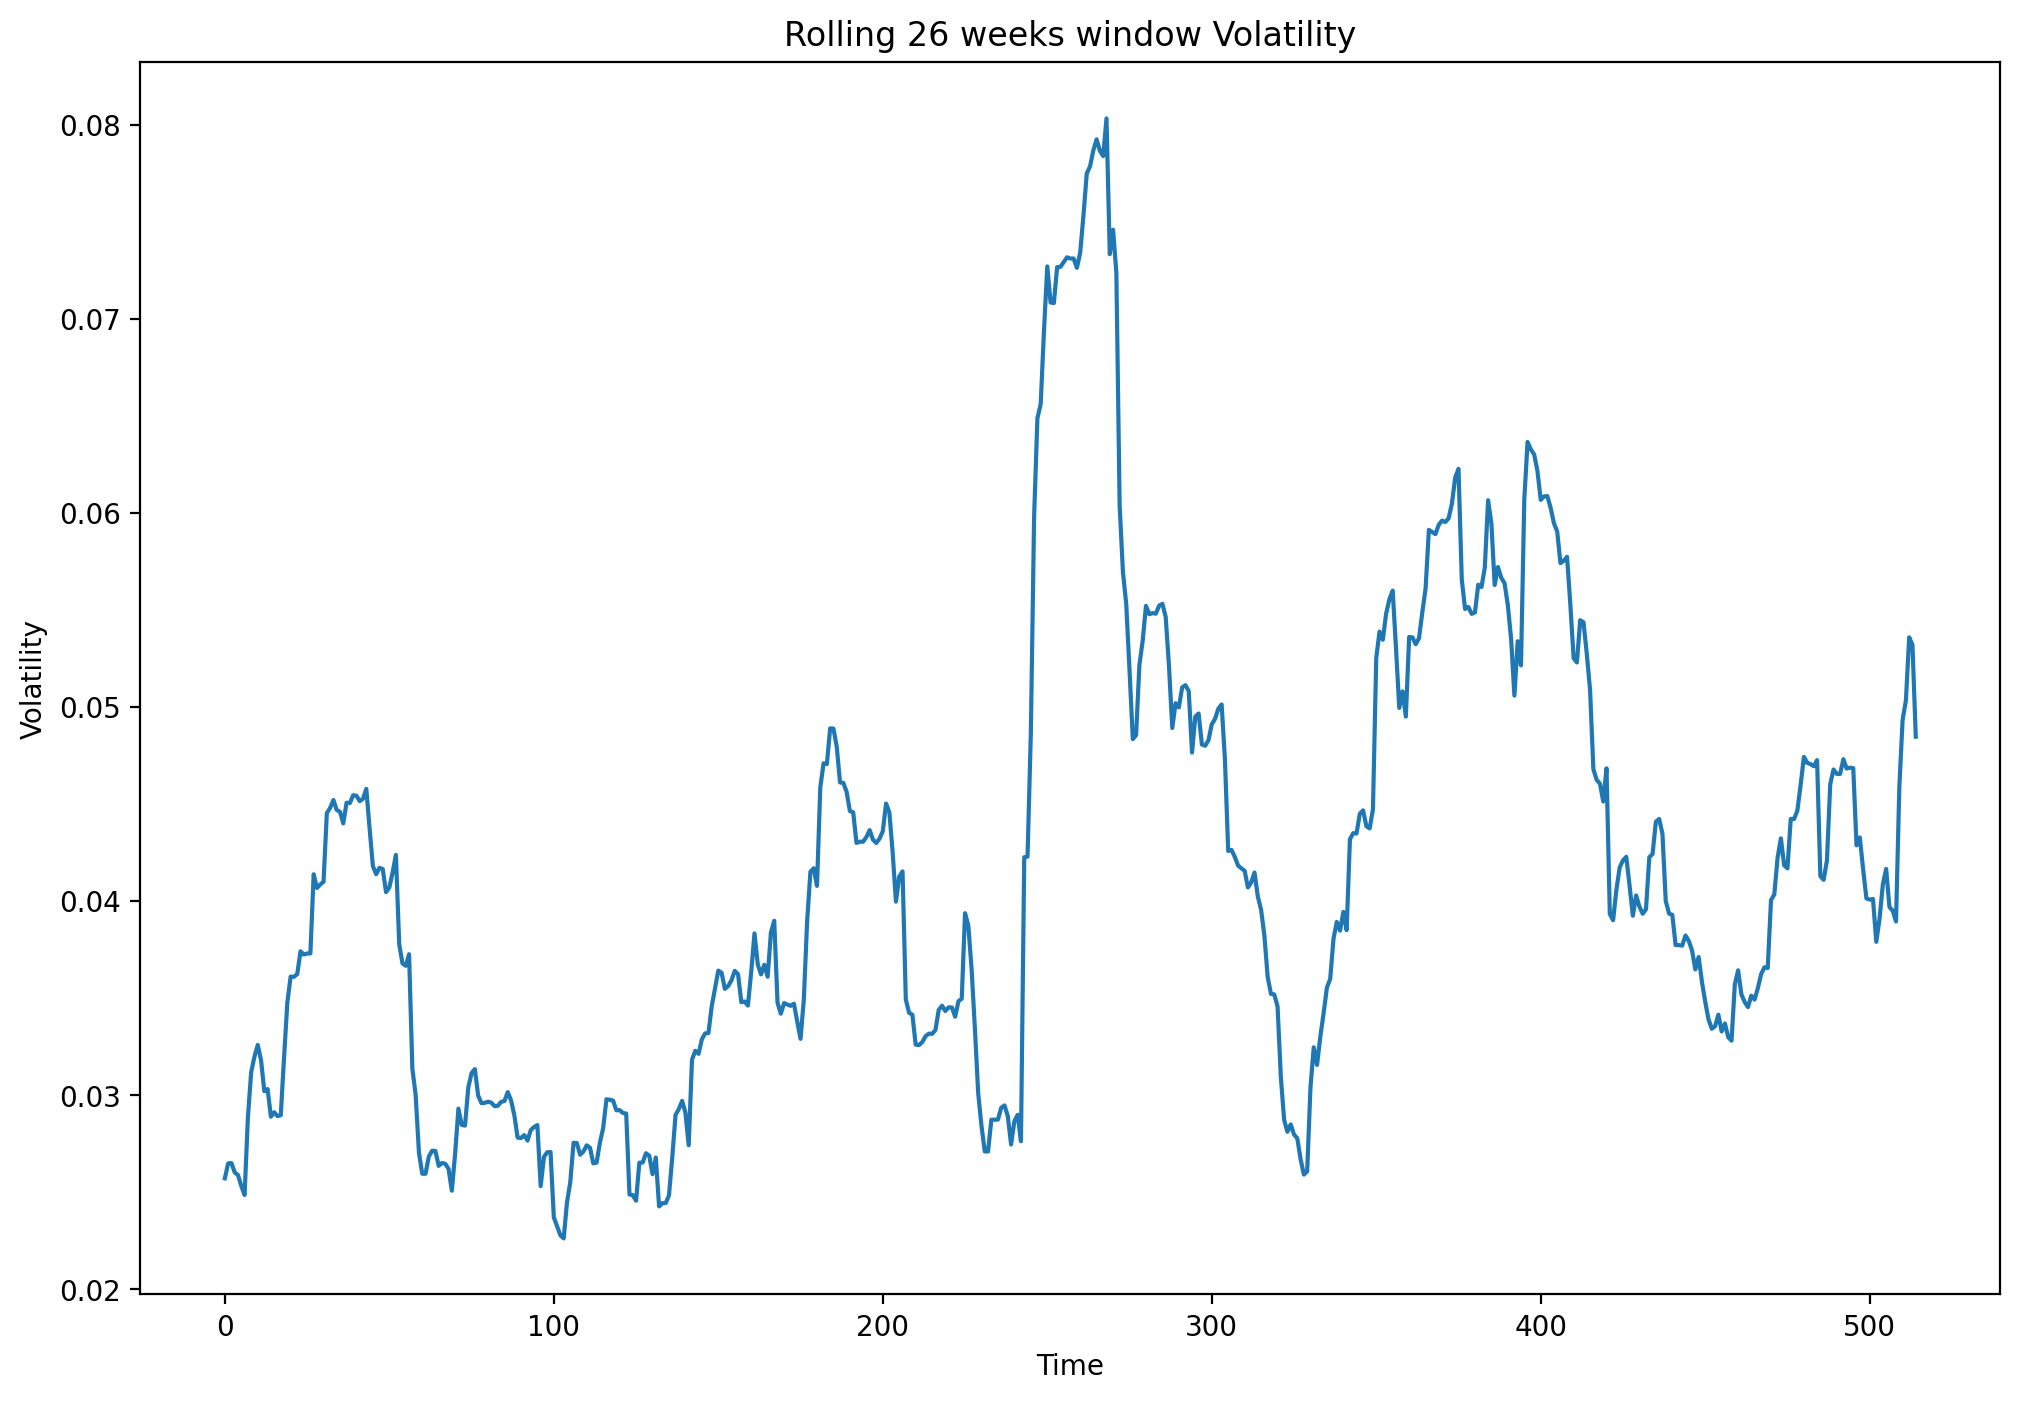

: 

: 

: 

: 

In [ ]:
## Volatility
vol = list()
for i in range(26, len(portfolio)-1):
    vol.append(portfolio[i-26:i].std())
    
plt.figure(figsize = (12, 8))
plt.plot(vol)
plt.title("Rolling 26 weeks window Volatility")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.show()

In [ ]:
lastVol = vol[-1]
annualizedVol = lastVol * np.sqrt(52)
normalVaR = 0 - 1.65 * lastVol
normalCVaR = 0 - lastVol * norm.pdf(-1.65) / 0.05
print(f"Annualized Volatility: {annualizedVol:.4f}")
print(f"Normal VaR: {normalVaR:.4f}")
print(f"Normal CVaR: {normalCVaR:.4f}")

Annualized Volatility: 0.3496
Normal VaR: -0.0800
Normal CVaR: -0.0992


: 

: 

: 

: 